In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline


In [2]:
swissDF  = pd.read_csv("swiss_reviews.csv")

One of the first thing we'll need to do is transform the categories, which are a string right now, into a list of string.

In [3]:
def transformToList(x):
    newList=[]
    for i in range(1, len(x)):
        if i%2 != 0 :
            newList.append(x[i])
    return newList


swissDF['categories'] = swissDF['categories'].apply(lambda x: x.split("'"))
swissDF['categories'] = swissDF['categories'].apply(lambda x : transformToList(x))

In [4]:
swissDF.drop('Unnamed: 0', axis=1, inplace=True)
swissDF.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,year,sentiment
0,B000R9AAJA,"[0, 0]",5.0,Speakers are loud and clear. They work great! ...,"11 22, 2012",A0023922YYT81KP1CWU4,Steven Caruso,Great!,1353542400,Logitech,"[Electronics, Computers & Accessories, Cables ...",2012,0.9476
1,B000R9AAJA,"[1, 1]",5.0,These I bought for my co-worker who always bor...,"02 3, 2014",A034570920WVP7XFWHZ5I,Olyvia,Co-Worker is happy,1391385600,Logitech,"[Electronics, Computers & Accessories, Cables ...",2014,0.9755
2,B000R9AAJA,"[1, 1]",5.0,I bought these speakers for a friend's birthda...,"02 2, 2013",A100FXXJZMM6PI,Phillip Ly,Logitech S-120 Speakers,1359763200,Logitech,"[Electronics, Computers & Accessories, Cables ...",2013,0.8867
3,B000R9AAJA,"[1, 1]",5.0,My brother bought this speaker set for me back...,"10 20, 2012",A10636NGTJRUHN,sande276,Great!,1350691200,Logitech,"[Electronics, Computers & Accessories, Cables ...",2012,0.9463
4,B000R9AAJA,"[1, 1]",5.0,I have had these for a while and they work lik...,"01 31, 2013",A1071EF3JDBGI0,"R. Lorente ""Picky""",EXCELLENT!,1359590400,Logitech,"[Electronics, Computers & Accessories, Cables ...",2013,0.8528


We'll first look at the overall ratings, all categories mixed together

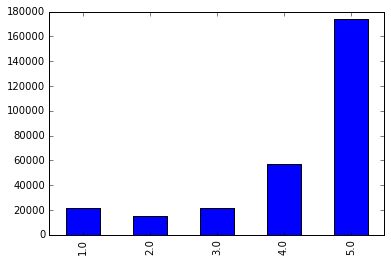

In [5]:
swissDF.overall.value_counts().sort_index().plot.bar()

The ratings are pretty high, but as we have determined before this is also the case for international products. So basing our observations on raw evaluations isn't enough, we'll try to separate them by categories and perform sentiment analysis

In [6]:
swissDF['year'] = swissDF['reviewTime'].astype(str)
swissDF['year'] = swissDF['year'].apply(lambda x: x[-4:])

In [7]:
yearGroup =swissDF.groupby(['year'])
yearGroup['overall'].agg(['count', 'mean'])

,count,mean
year,,
2000,12,4.416667
2001,49,3.918367
2002,70,3.942857
2003,205,4.136585
2004,307,3.491857
2005,826,3.984262
2006,1893,4.078711
2007,5514,4.273486
2008,7366,4.250068


The mean seems pretty consistent. with a few exceptions like 2004 which is probably due to a very inpopular product released back then. It also seems like the number of reviews is increasing exponentially.

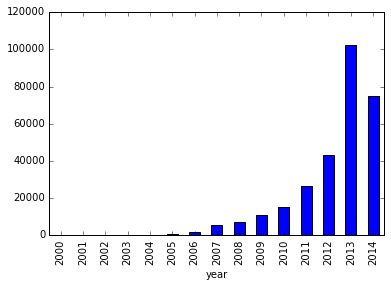

In [8]:
yearGroup['overall'].count().plot.bar()

2014 might seem smaller than 2013, but this data was collected in July 2014 which explains it.

We will now look at the dsitribution of reviews among swiss brands. Because some of them are much more popular than others (logitech being the most popular one) we will plot it using a logarithmic scale

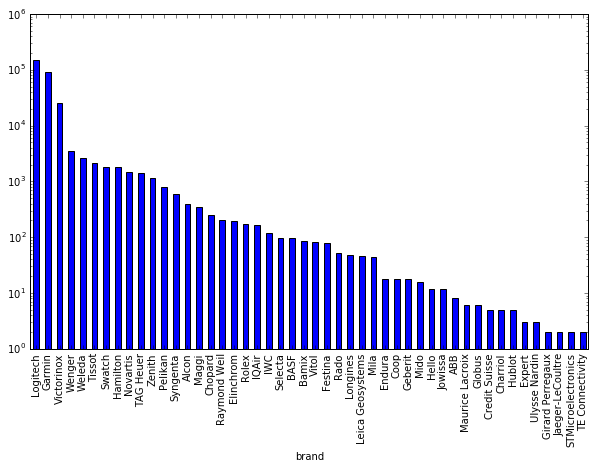

In [9]:
swissDF.groupby(['brand'])['brand'].count().sort_values(ascending=False).plot.bar(log=True, figsize=(10, 6))

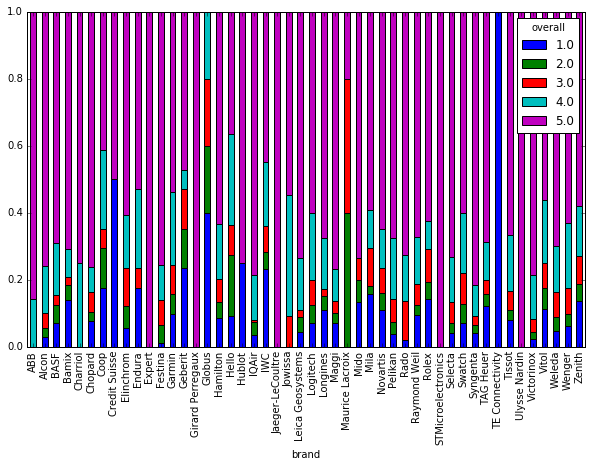

In [10]:
brandScore = swissDF.groupby(['brand', 'overall'])['brand']
brandScore = brandScore.count().unstack('overall')
brandScore.div(brandScore.sum(1), 0).plot(kind='bar', stacked=True, figsize=(10,6))
#problem here, the ratings are also put on a log scale so it seems like there are too many 1s. We could try to fix it or replace
#by piecharts

We will now group the reviews by category

In [11]:
categoriesCount = pd.DataFrame(swissDF['categories'].tolist()).stack().value_counts()
categoriesCount

Electronics                         218203
Computers & Accessories             116378
Cables & Accessories                 94113
GPS & Navigation                     75883
Clothing, Shoes & Jewelry            45919
Vehicle GPS                          35114
Mice                                 34120
Sports & Handheld GPS                27265
Sports & Outdoors                    22381
Accessories                          20312
Trucking GPS                         18019
Keyboards                            17910
Computer Speakers                    15715
Accessories & Supplies               14218
Audio & Video Accessories            13939
Running GPS Units                    13849
Remote Controls                      13794
Outdoor Gear                         11784
Camping & Hiking                     11764
Knives & Tools                       11745
GPS System Accessories               11507
TV Remote Controls                   11079
Folding Knives                       10973
Handheld GP

Let's focus on the most reviewed categories

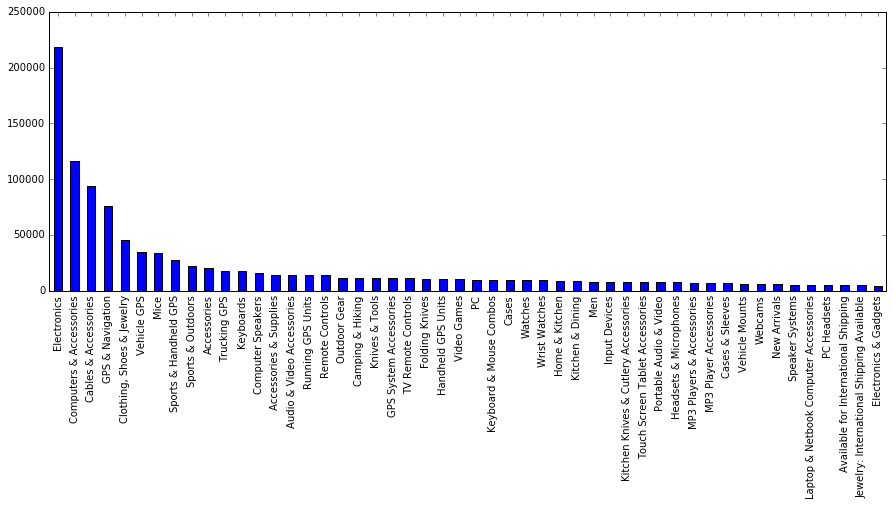

In [12]:
categoriesCount = categoriesCount.head(50)
categoriesCount.plot.bar(figsize=(15,5))

We will now take a look at how well rated each of these categories are

In [13]:
categoriesCount.keys()

Index(['Electronics', 'Computers & Accessories', 'Cables & Accessories',
       'GPS & Navigation', 'Clothing, Shoes & Jewelry', 'Vehicle GPS', 'Mice',
       'Sports & Handheld GPS', 'Sports & Outdoors', 'Accessories',
       'Trucking GPS', 'Keyboards', 'Computer Speakers',
       'Accessories & Supplies', 'Audio & Video Accessories',
       'Running GPS Units', 'Remote Controls', 'Outdoor Gear',
       'Camping & Hiking', 'Knives & Tools', 'GPS System Accessories',
       'TV Remote Controls', 'Folding Knives', 'Handheld GPS Units',
       'Video Games', 'PC', 'Keyboard & Mouse Combos', 'Cases', 'Watches',
       'Wrist Watches', 'Home & Kitchen', 'Kitchen & Dining', 'Men',
       'Input Devices', 'Kitchen Knives & Cutlery Accessories',
       'Touch Screen Tablet Accessories', 'Portable Audio & Video',
       'Headsets & Microphones', 'MP3 Players & Accessories',
       'MP3 Player Accessories', 'Cases & Sleeves', 'Vehicle Mounts',
       'Webcams', 'New Arrivals', 'Speaker Systems

To find the entries that contain one category, the code to use looks like this

In [14]:
swissDF.categories.apply(lambda x: ' '.join(x)).str.contains('Electronics')

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
          ...  
289848    False
289849    False
289850    False
289851     True
289852     True
289853    False
289854    False
289855    False
289856     True
289857    False
289858    False
289859     True
289860     True
289861     True
289862     True
289863     True
289864     True
289865    False
289866    False
289867    False
289868    False
289869    False
289870     True
289871     True
289872     True
289873     True
289874    False
289875    False
289876    False
289877    False
Name: categories, dtype:

In [15]:
res = pd.DataFrame(columns=('category', 'mean'))
i=0
for val in categoriesCount.keys():
    mean = swissDF[swissDF.categories.apply(lambda x: ' '.join(x)).str.contains(val)].overall.mean()
    res.loc[i] = [val,mean]
    i=i+1

In [16]:
res.head()

,category,mean
0,Electronics,4.151909
1,Computers & Accessories,4.237529
2,Cables & Accessories,4.240466
3,GPS & Navigation,4.077727
4,"Clothing, Shoes & Jewelry",4.236315


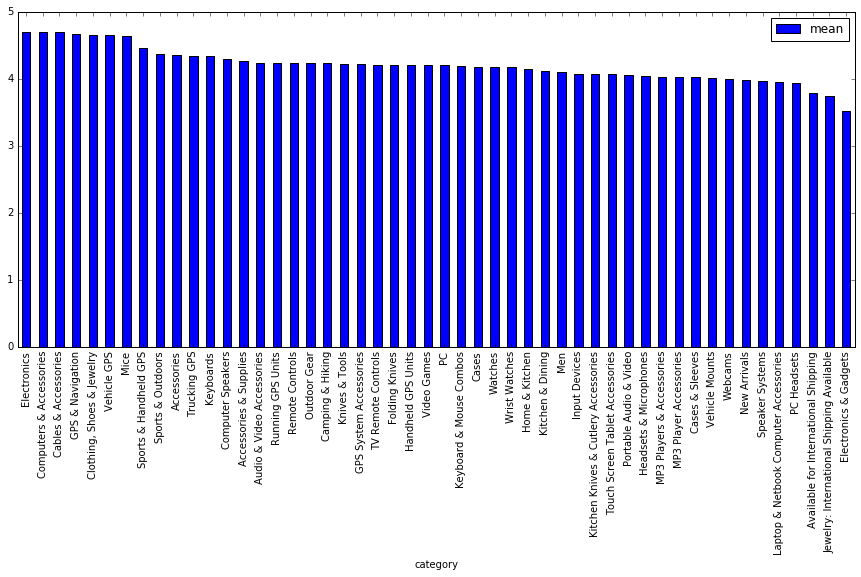

In [17]:
res.sort_values(by='mean',ascending=False).plot.bar(x = res.category, figsize=(15,6))
#TODO plot international products of same category on the side + maths on correlations

The last thing we need to check is to see what happens if we group the reviews first by proudct. This will show us if for example some very popluar results are skewing the meands

In [18]:
productGroup = swissDF.groupby(['asin'])
productFrame = pd.DataFrame(productGroup['overall'].agg(['count', 'mean']))
overallGrouped = productFrame['mean']

In [19]:
productFrame.count()

count    4718
mean     4718
dtype: int64

We can see that we have 4718 unique prodcuts in total. 
Now let's get the mean product wise

In [20]:
print(np.mean(productFrame['mean']))
print(np.median(productFrame['mean']))

4.246266143689977
4.44117647059


Evrything looks normal, which means that we have a realtivly normal distrubtion of the reviews accros the products

In [21]:
productFrame['asin'] = productFrame.index
productFrame['brand'] = productGroup.apply(lambda x: list(x.brand)[0])
productFrame.index = range(0, 4718)
productFrame.groupby(['brand'])['mean'].agg(['count', 'mean', 'median']).sort_values(['count'])

,count,mean,median
brand,,,
Ulysse Nardin,1,5.000000,5.000000
TE Connectivity,1,1.000000,1.000000
STMicroelectronics,1,5.000000,5.000000
Credit Suisse,1,3.000000,3.000000
Jaeger-LeCoultre,1,5.000000,5.000000
Girard Perregaux,1,5.000000,5.000000
Mila,2,4.146718,4.146718
IQAir,2,4.621212,4.621212
Expert,2,5.000000,5.000000


This is very nice view as it shows us whihc brands have the most products as well as the mean and the median review for each brand. 
In general we can say that most brands escialy the most popoluar ones are very close to the general mean and distribtuion

# TEXT ANALYSIS

Now that we have finished working with the numerical ratings, we'll try to look for differences between Swiss and international products by basing our analysis on text.
First we'll start with the "summary" column

In [22]:
from nltk.sentiment.vader import *

D:\Program Files (x86)\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


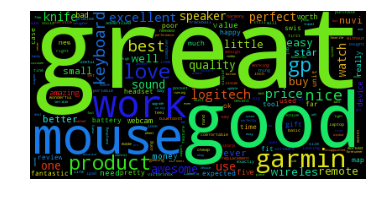

In [23]:
summaryBody = swissDF['summary'].apply(lambda x: x.lower())
textArray = summaryBody.values.flatten()
textString = ' '.join(textArray)
cloud = WordCloud().generate(textString)
plt.imshow(cloud)
plt.axis('off')
plt.show()

The code below was run to execute the sentiment analysis of the reviews, we have now commented it because the result was added to the dataframe

In [24]:
#analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer()

We will now perform sentiment analysis on the review text joined with the summary

In [25]:
#review_polarity = []
#for i in range (0, len(swissDF['reviewText'])):
#    review_polarity.append(analyzer.polarity_scores(' '.join([str(swissDF['reviewText'][i]), swissDF['summary'][i]]))['compound'])
#    if i % 1000 == 0:
#        print(i)

In [26]:
#len(review_polarity)

In [27]:
#swissDF['sentiment'] = review_polarity

In [28]:
swissDF['sentiment'].head()

0    0.9476
1    0.9755
2    0.8867
3    0.9463
4    0.8528
Name: sentiment, dtype: float64

In [29]:
productGroup = swissDF.groupby(['asin'])
productFrame = pd.DataFrame(productGroup['sentiment'].agg(['count', 'mean']))


In [30]:
print("Mean of sentiment")
print(np.mean(productFrame['mean']))
print(np.median(productFrame['mean']))

Mean of sentiment
0.6534338998560479
0.72615


In [31]:
productFrame['asin'] = productFrame.index
productFrame['brand'] = productGroup.apply(lambda x: list(x.brand)[0])
productFrame.index = range(0, 4718)
productFrame.groupby(['brand'])['mean'].agg(['count', 'mean', 'median']).sort_values(['count'], ascending=False)

,count,mean,median
brand,,,
Victorinox,1056,0.712119,0.779360
Garmin,780,0.501308,0.547487
Logitech,595,0.629216,0.688054
Hamilton,378,0.661859,0.794742
Tissot,311,0.712240,0.790889
Swatch,219,0.653385,0.731450
TAG Heuer,211,0.702715,0.774700
Wenger,199,0.665085,0.742008
Pelikan,156,0.706711,0.819700


In [32]:
np.corrcoef(swissDF['overall'], swissDF['sentiment'])

array([[ 1.        ,  0.55085136],
       [ 0.55085136,  1.        ]])

The correlation is 0.55, which indicates a moderatetly high correlation between the overall rating and the review

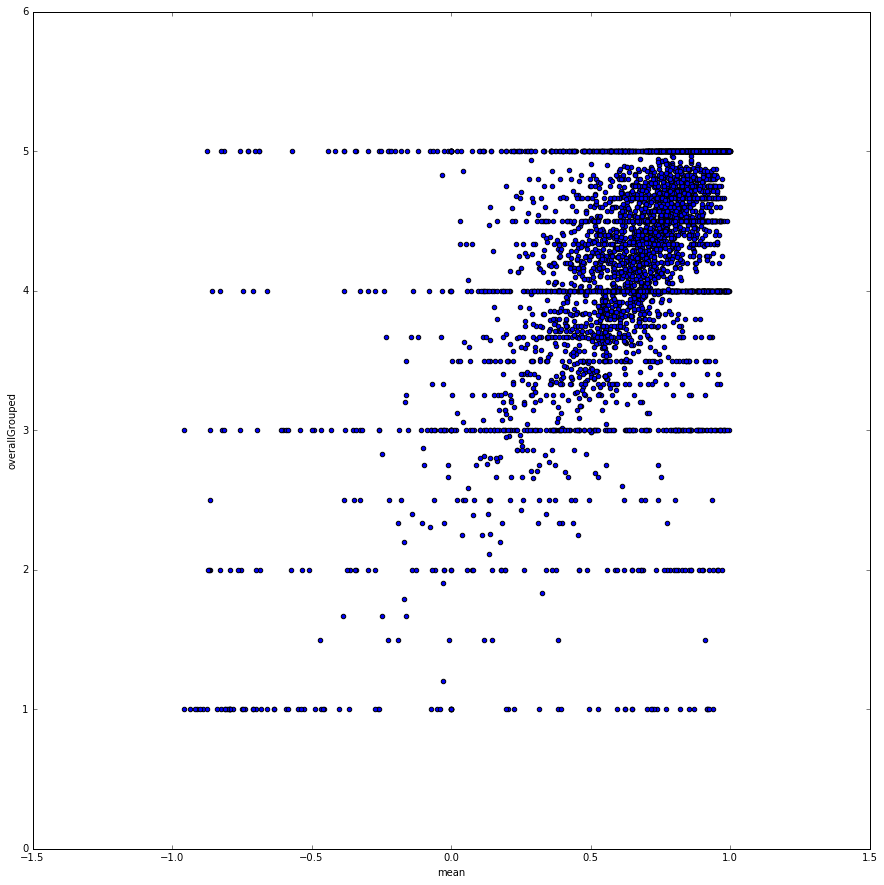

In [33]:
productFrame['overallGrouped'] = overallGrouped
A = np.vstack([productFrame['mean'].tolist(),np.ones(len(productFrame['mean'].tolist()))]).T
xarr = np.array(productFrame['mean'].tolist())
m,c = np.linalg.lstsq(A,productFrame['overallGrouped'].tolist())[0]

productFrame['overallGrouped'] = overallGrouped.tolist()
productFrame['regression'] = (xarr*m + c)
ax = productFrame.plot.scatter(x='mean', y='regression', color="Red")
productFrame.plot.scatter(x='mean', y='overallGrouped' ,figsize=(15,15), ax=ax)